In [1]:
import sqlite3
import pandas as pd
from lightgbmlss.model import *
from lightgbmlss.distributions.Weibull import *
import lightgbm as lgb
import numpy as np
from lightgbmlss.distributions.Gaussian import *
from lightgbmlss.distributions.Mixture import *
from lightgbmlss.distributions.mixture_distribution_utils import MixtureDistributionClass

from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
figure_size = (8,4)
import plotnine
from plotnine import *
plotnine.options.figure_size = figure_size

conn = sqlite3.connect('../../../data/nfp2/nfp2_combined.db')  # Adjust the path to your database file

# Step 2 & 3: Query the database and load the data into a pandas DataFrame
query = "SELECT * FROM stellarators_combined"  # Adjust your query as needed
data_df = pd.read_sql_query(query, conn)

data_df_clean = data_df[data_df['convergence'] == 1]
data_df_clean = data_df_clean.dropna(subset=['quasiisodynamic'])


X = data_df_clean[['rbc_1_0', 'rbc_m1_1', 'rbc_0_1', 'rbc_1_1','zbs_1_0', 'zbs_m1_1', 'zbs_0_1', 'zbs_1_1']] 
Y = np.log(data_df_clean['quasiisodynamic'])

features_no_outliers, test_features_no_outliers, target_no_outliers, test_target_no_outliers = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create the Dataset with max_bin parameter specified
dtrain = lgb.Dataset(features_no_outliers, label=target_no_outliers.values)

In [2]:
from lightgbmlss.model import LightGBMLSS  # Ensure this import matches your actual usage

lgblss = LightGBMLSS(
    Mixture(
        Gaussian(response_fn="softplus"), 
        M = 2,
        tau=1.0,
        hessian_mode="individual",
    )
)

opt_params = {
    "max_depth": 113,
    "num_leaves": 114,
    "min_data_in_leaf": 1537,
    "min_gain_to_split": 0.011698795932704837,
    "min_sum_hessian_in_leaf": 0.01321079065291914,
    "subsample": 0.8580461591753848,  # Original value retained
    "subsample_freq": 17,              # Original value retained
    "feature_fraction": 0.9786304627265173,
    "boosting_type": "gbdt",
    "learning_rate": 0.34583344744652667,
    "max_delta_step": 0.46888176823970534,
    "feature_pre_filter": False,
    "boosting": "gbdt",  # Updated from the provided params
    "opt_rounds": 200,   # Original value retained
    "device_type": "cpu",
    "num_class": 6,
    "metric": "None",
    "objective": "<bound method MixtureDistributionClass.objective_fn of <lightgbmlss.distributions.Mixture.Mixture object>>",  # Reference to the method, assuming the object stays consistent.
    "random_seed": 123,
    "verbose": -1
}



n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

lgblss.train(opt_params, dtrain, num_boost_round=n_rounds)

print("Model trained successfully")

# Seed for reproducibility in torch operations
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 10000  # Use the number of rows in X_test as the number of samples

# Quantiles to calculate from predicted distribution
quant_sel = [0.25, 0.75]

# Sample from predicted distribution
pred_samples = lgblss.predict(
    test_features_no_outliers,
    pred_type="samples",
    n_samples=n_samples,
    seed=123
)

print('predicted samples')

# Calculate quantiles from predicted distribution
pred_quantiles = lgblss.predict(
    test_features_no_outliers,
    pred_type="quantiles",
    n_samples=n_samples,
    quantiles=quant_sel
)

print('predicted params')

# Return predicted distributional parameters
pred_params = lgblss.predict(
    test_features_no_outliers,
    pred_type="parameters"
)
print(pred_params)
print('antes do plot')

/home/exouser/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML


Model trained successfully
predicted samples
predicted params
          loc_1     loc_2   scale_1   scale_2  mix_prob_1  mix_prob_2
0     -5.566408 -2.661429  0.666343  1.026549    0.148497    0.851503
1     -4.555511 -1.563607  1.412959  0.050581    0.740305    0.259695
2     -7.429456 -4.284760  0.756688  1.415467    0.943867    0.056133
3     -6.481869 -4.491514  0.319019  1.089982    0.996996    0.003004
4     -3.998032 -2.260056  0.945561  0.299131    0.264203    0.735797
...         ...       ...       ...       ...         ...         ...
91493 -5.634991 -2.346074  1.659887  0.632479    0.977958    0.022042
91494 -5.956132 -2.971272  0.672896  0.972515    0.658471    0.341529
91495 -6.386095 -4.700347  0.573694  1.453204    0.997714    0.002286
91496 -6.201145 -2.058027  1.839444  0.877710    0.995443    0.004557
91497 -4.955274 -2.094238  1.421868  0.485972    0.792831    0.207169

[91498 rows x 6 columns]
antes do plot


In [3]:
# %pip install --force-reinstall altair


In [27]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
matplotlib.use('Agg')  # Optional: Use a non-interactive backend for saving


# Set global font sizes (before creating the plot)
rcParams['font.size'] = 25
rcParams['axes.titlesize'] = 25
rcParams['axes.labelsize'] = 25
rcParams['xtick.labelsize'] = 25
rcParams['ytick.labelsize'] = 25
rcParams['legend.fontsize'] = 25

# Generate the plot
lgblss.plot(
    test_features_no_outliers,
    parameter="mix_prob_1",
    plot_type="Feature_Importance"
)

# Get the current figure and axis
fig = plt.gcf()  # Current figure
ax = plt.gca()   # Current axis

# Explicitly update tick font sizes (override global settings if needed)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.set_xlabel(ax.get_xlabel(), fontsize=25)

# Check for legend and update font size if present
legend = ax.get_legend()
if legend is not None:
    for text in legend.get_texts():
        text.set_fontsize(25)

# Adjust any text annotations on the plot (if present)
for text in ax.texts:
    text.set_fontsize(25)

# Ensure the layout fits properly
plt.tight_layout()

# Save the updated plot
fig.savefig('plot_updated.pdf', format='pdf')

# Close the figure
plt.close(fig)


In [5]:
# from plotnine import ggplot, aes, geom_point, geom_vline, stat_density, facet_wrap, labs, theme_bw, scale_fill_brewer, theme, element_text, element_blank

# y_pred = []

# n_examples = 9

# for i in range(n_examples):    
#     y_samples = pd.DataFrame(pred_samples.values[i,:].reshape(-1,1), columns=["PREDICT_DENSITY"])
#     y_samples["PREDICT_POINT"] = y_samples["PREDICT_DENSITY"].mean()
#     y_samples["PREDICT_Q05"] = y_samples["PREDICT_DENSITY"].quantile(q=quant_sel[0])
#     y_samples["PREDICT_Q95"] = y_samples["PREDICT_DENSITY"].quantile(q=quant_sel[1])
#     y_samples["ACTUAL"] = test_target_no_outliers.iloc[i]
#     y_samples["obs"]= f"Obervation {i+1}"
#     y_pred.append(y_samples)
    
# pred_df = pd.melt(pd.concat(y_pred, axis=0), id_vars="obs")
# pred_df["obs"] = pd.Categorical(pred_df["obs"], categories=[f"Obervation {i+1}" for i in range(n_examples)])
# df_actual, df_pred_dens, df_pred_point, df_q05, df_q95 = [x for _, x in pred_df.groupby("variable")]

# plot_pred = (
#     ggplot(pred_df,
#            aes(color="variable")) + 
#     stat_density(df_pred_dens,
#                  aes(x="value"),
#                  size=1.1) + 
#     geom_point(df_pred_point,
#                aes(x="value",
#                    y=0),
#                size=1.4) + 
#     geom_point(df_actual,
#                aes(x="value",
#                    y=0),
#                size=1.4) + 
#     geom_vline(df_q05, 
#                aes(xintercept="value",
#                    fill="variable",
#                    color="variable"),
#                linetype="dashed",
#                size=1.1) + 
#     geom_vline(df_q95, 
#                aes(xintercept="value",
#                    fill="variable",
#                    color="variable"),
#                linetype="dashed",
#                size=1.1) + 
#     facet_wrap("obs",
#                scales="free",
#                ncol=3) + 
#     labs(title=" \n",
#          x = "") + 
#     theme_bw(base_size=15) +
#     scale_fill_brewer(type="qual", palette="Dark2") + 
#     theme(legend_position="bottom",
#           plot_title = element_text(hjust = 0.5),
#           legend_title = element_blank()
#          )
# )

# print(plot_pred)

In [6]:
pred_samples

pred_samples.iloc[:, 0:10]

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9
0,-1.461650,-4.871292,-2.671422,-5.073606,-2.420336,-1.260692,-1.842868,-2.622898,-4.293604,-7.145385
1,-5.976160,-1.577682,-1.658566,-1.565312,-5.857856,-6.865916,-1.508914,-1.576051,-7.814819,-1.560889
2,-7.642410,-7.710410,-8.445824,-5.599346,-8.049905,-7.260371,-7.594326,-7.784840,-7.926055,-6.888771
3,-6.687045,-7.098788,-6.563293,-6.305367,-6.195848,-6.756851,-6.460126,-5.684527,-6.483830,-6.819963
4,-2.322178,-2.622307,-2.230517,-4.513721,-2.173498,-1.900938,-2.218861,-2.343992,-4.874217,-2.397111
...,...,...,...,...,...,...,...,...,...,...
91493,-3.056886,-4.608625,-5.608656,-4.907860,-6.373253,-4.872965,-5.436266,-1.937830,-3.421005,-6.005697
91494,-3.841820,-6.489080,-1.141147,-5.758967,-4.678200,-5.244740,-3.024633,-2.914134,-6.567575,-1.345781
91495,-5.528389,-6.403863,-5.539582,-7.319136,-6.133145,-7.080392,-5.625215,-6.463278,-5.325248,-6.934536
91496,-7.594465,-6.319561,-10.910128,-4.306472,-6.764264,-2.904423,-5.392529,-8.647255,-5.410901,-7.495798


In [7]:
pred_samples[pred_samples.columns.to_series().sample(2)]

,y_sample7866,y_sample9392
0,-3.769030,-1.504302
1,-1.495900,-2.218235
2,-7.352088,-8.502813
3,-6.907008,-6.487072
4,-3.599646,-3.125469
...,...,...
91493,-5.545961,-5.190156
91494,-6.857475,-5.188589
91495,-6.980972,-6.204808
91496,-7.155574,-3.701898


In [8]:
# figure_size = (10,5)

# n_subset = 10
# #pred_df = pred_samples.iloc[:, 0:n_subset]
# pred_df = pred_samples[pred_samples.columns.to_series().sample(n_subset)]
# pred_df.columns = [f"Sample {i+1}" for i in range(n_subset)]

# # Convert the pandas Series to a NumPy array and reshape it
# actual_df = pd.DataFrame(test_target_no_outliers.values.reshape(-1,), columns=["Actual"])

# plot_df = pd.concat([pred_df, actual_df], axis=1)
# linestyles = ["--" for _ in range(n_subset)] + ["solid"]
# linewidths = [1 for _ in range(n_subset)] + [2.5]

# plt.figure(figsize=figure_size)
# for idx, col in enumerate(plot_df.columns):
#     sns.kdeplot(plot_df[col], linestyle=linestyles[idx], lw=linewidths[idx], label=col)
# plt.legend()
# plt.title("  ")
# plt.gca().set_xlabel("Log(quasisymmetry)", fontsize = 14)
# plt.gca().set_ylabel("Density", fontsize = 14)
# plt.show()


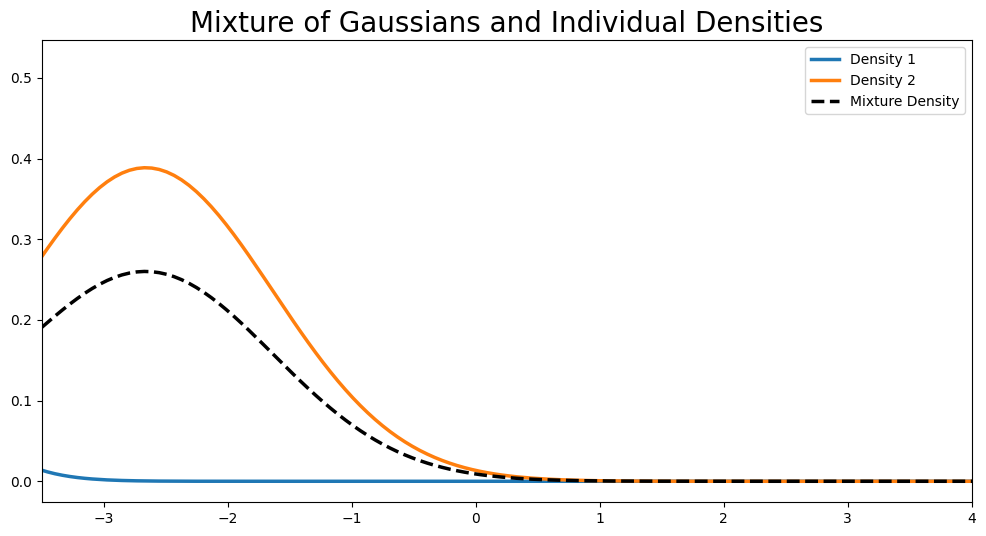

Weights for each Gaussian component:
Weight for Gaussian 1: 0.3311
Weight for Gaussian 2: 0.6689


In [9]:
from scipy.stats import norm  # Importing norm for Gaussian density calculation

mix_params = torch.split(torch.tensor(pred_params.values[0, :]).reshape(1, -1), lgblss.dist.M, dim=1)
mix_params[1][0][0] = mix_params[1][0][0] + torch.tensor(0.1)  # Increase the std of the first density for plotting reasons

# Create Mixture-Distribution
torch.manual_seed(123)
mix_dist = lgblss.dist.create_mixture_distribution(mix_params)
gaus_dist = mix_dist._component_distribution
gaus_samples = pd.DataFrame(
    gaus_dist.sample((test_target_no_outliers.shape[0],)).reshape(-1, lgblss.dist.M).numpy(),
    columns=[f"Density {i + 1}" for i in range(lgblss.dist.M)]
)

# Extract means, stds, and weights from mix_params
means = mix_params[0][0].detach().numpy()
stds = mix_params[1][0].detach().numpy()
weights = torch.nn.functional.softmax(mix_params[2][0], dim=0).detach().numpy()  # Assuming the last split part contains the weights logits

# Define a range for the x-axis
x = np.linspace(-10, 50, 1000)

# Plot individual Gaussian densities
plt.figure(figsize=(12, 6))
for i in range(lgblss.dist.M):
    y = norm.pdf(x, loc=means[i], scale=stds[i])
    sns.lineplot(x=x, y=y, lw=2.5, label=f"Density {i + 1}")

# Calculate and plot mixture density
mixture_density = np.zeros_like(x)
for i in range(lgblss.dist.M):
    mixture_density += weights[i] * norm.pdf(x, loc=means[i], scale=stds[i])

sns.lineplot(x=x, y=mixture_density, lw=2.5, color='k', label='Mixture Density', linestyle='--')

plt.title("Mixture of Gaussians and Individual Densities", fontsize=20)
plt.legend()
plt.xlim(-3.5, 4)
plt.show()

# Print the weights for each Gaussian
print("Weights for each Gaussian component:")
for i, w in enumerate(weights):
    print(f"Weight for Gaussian {i + 1}: {w:.4f}")

In [10]:
pred_samples.median(axis=1)

0       -2.862593
1       -3.932611
2       -7.378947
3       -6.486584
4       -2.379675
           ...   
91493   -5.578836
91494   -5.460162
91495   -6.385038
91496   -6.181404
91497   -4.462385
Length: 91498, dtype: float32

Predicted medians calculated


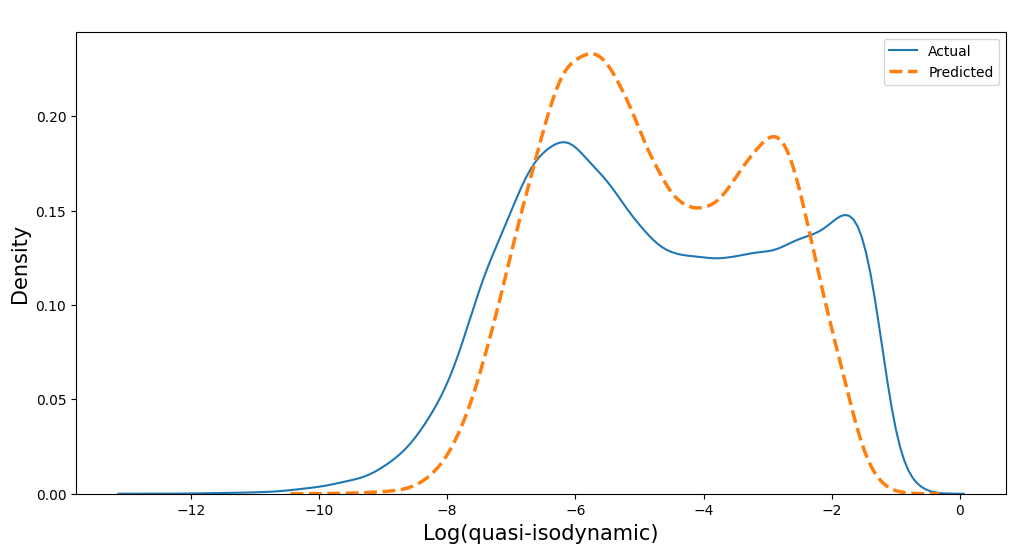

In [11]:
pred_medians = pred_samples.median(axis=1)
print('Predicted medians calculated')

actual_df = pd.DataFrame(test_target_no_outliers.values, columns=["Actual"])
median_df = pd.DataFrame(pred_medians.values, columns=["Median Predicted"])

plot_df = pd.concat([actual_df, median_df], axis=1)

# Plot the density estimation
plt.figure(figsize=(12, 6))
sns.kdeplot(plot_df["Actual"], label="Actual", linestyle="solid", lw=1.5)
sns.kdeplot(plot_df["Median Predicted"], label="Predicted", linestyle="--", lw=2.5)
plt.legend()
plt.title("  ")
plt.xlabel("Log(quasi-isodynamic)", fontsize=15)
plt.ylabel("Density", fontsize=15)
plt.savefig('10predicted_densities.pdf')
plt.show()

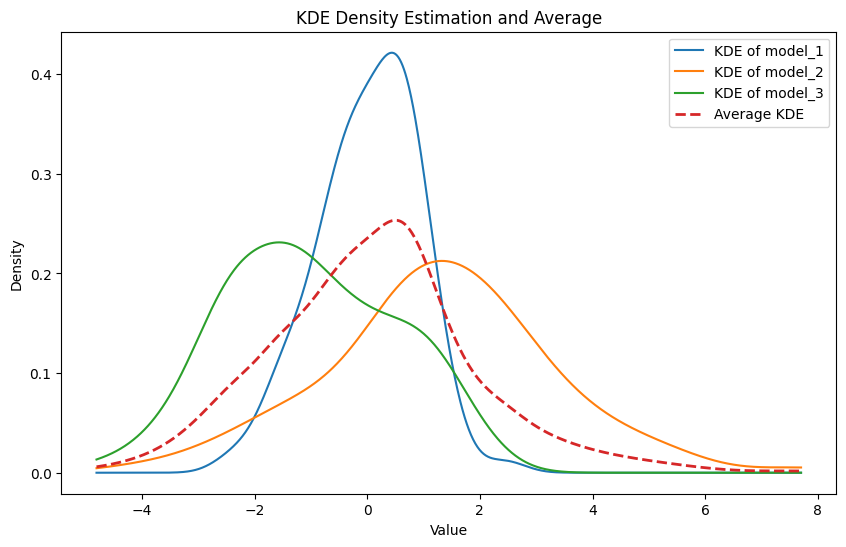

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Assuming your DataFrame is named df
df = pd.DataFrame({
    'model_1': np.random.normal(0, 1, 100),
    'model_2': np.random.normal(1, 2, 100),
    'model_3': np.random.normal(-1, 1.5, 100)
})

# Define a common grid
x_grid = np.linspace(df.values.min(), df.values.max(), 1000)

# Calculate KDE for each column
kde_estimates = []
for column in df.columns:
    kde = gaussian_kde(df[column])
    kde_estimates.append(kde(x_grid))

# Convert to numpy array for easier averaging
kde_estimates = np.array(kde_estimates)

# Average the KDEs
average_kde = np.mean(kde_estimates, axis=0)

# Plot the result
plt.figure(figsize=(10, 6))
for i, column in enumerate(df.columns):
    plt.plot(x_grid, kde_estimates[i], label=f'KDE of {column}')
plt.plot(x_grid, average_kde, label='Average KDE', linewidth=2, linestyle='--')
plt.legend()
plt.title('KDE Density Estimation and Average')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()


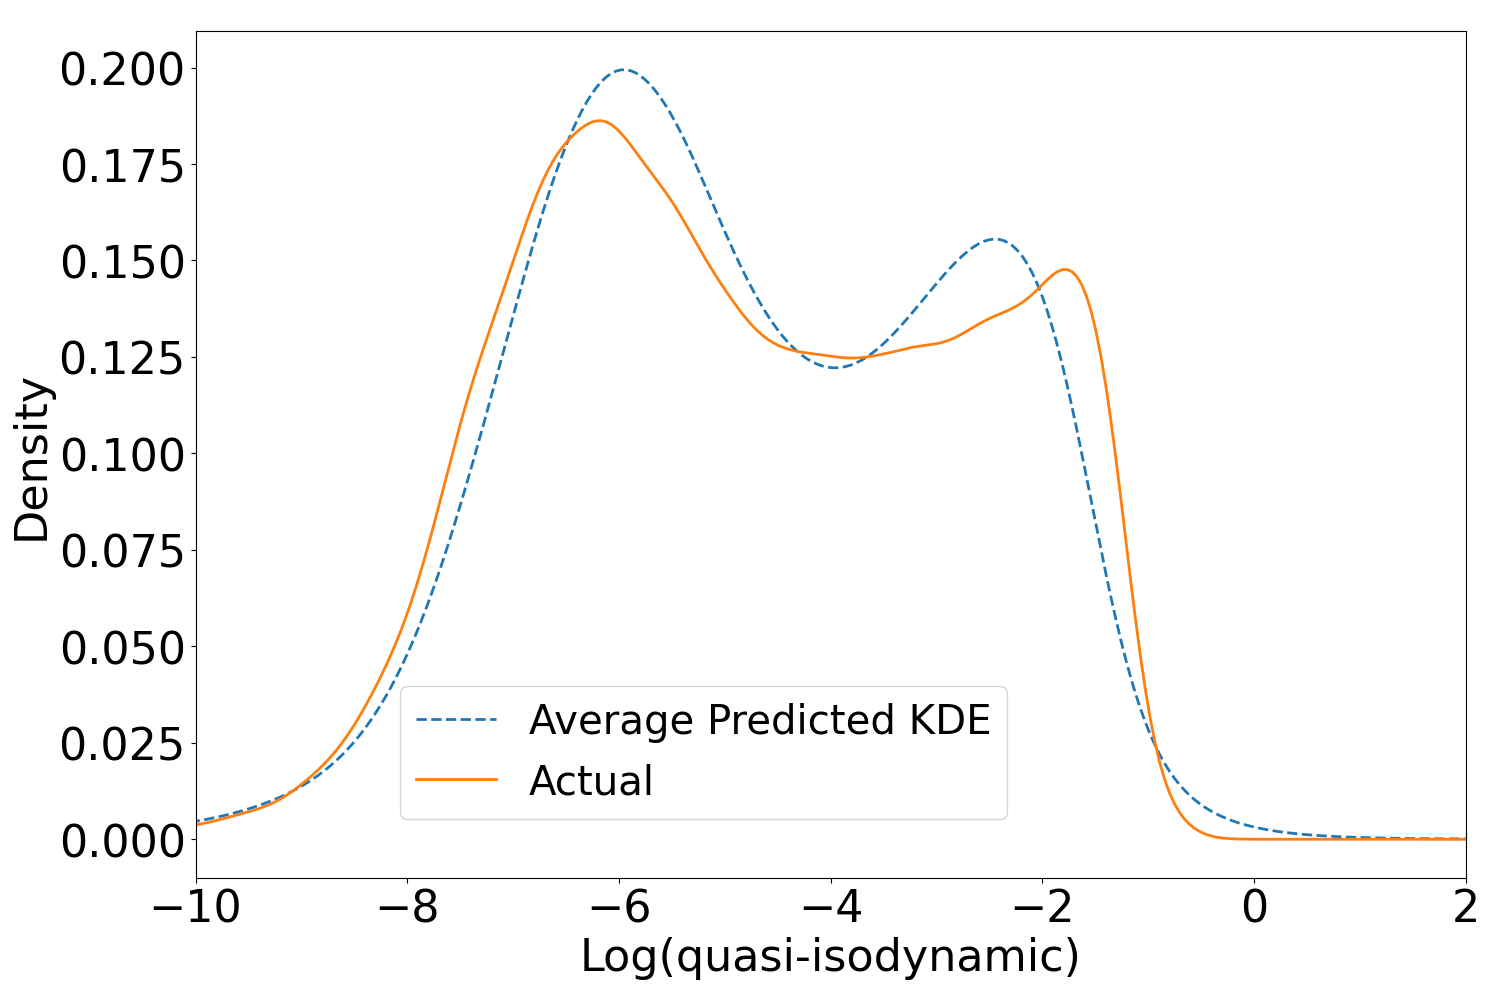

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

x_grid = np.linspace(pred_samples.values.min(), pred_samples.values.max(), 700)
pred_columns = pred_samples.columns.to_series().sample(2000)
# Calculate KDE for each column
kde_estimates = []
for column in pred_columns:
    kde = gaussian_kde(pred_samples[column])
    kde_estimates.append(kde(x_grid))

# Convert to numpy array for easier averaging
kde_estimates = np.array(kde_estimates)

# Average the KDEs
average_kde = np.mean(kde_estimates, axis=0)

actual_df = pd.DataFrame(test_target_no_outliers.values.reshape(-1,), columns=["Actual"])

kde = gaussian_kde(actual_df['Actual'].values)
kde_actual_estimates = kde(x_grid)

# Convert to numpy array for easier averaging
kde_actual_estimates = np.array(kde_actual_estimates)

# Plot the result
plt.figure(figsize=(15, 10))
plt.plot(x_grid, average_kde, label='Average Predicted KDE', linewidth=2, linestyle='--')
plt.plot(x_grid, kde_actual_estimates, label='Actual', linewidth=2, linestyle='-')

# Position the legend below the plot
plt.legend(fontsize=29, loc='upper center', bbox_to_anchor=(0.4, 0.25))

# Add labels and format
plt.title('  ')
plt.xlabel('Log(quasi-isodynamic)', fontsize=32)
plt.xlim(-10, 2)
plt.ylabel('Density', fontsize=32)
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)

# Adjust layout to prevent clipping
plt.tight_layout()

# Save the plot
plt.savefig('10predicted_densities.pdf', bbox_inches='tight')
plt.show()


In [14]:
import numpy as np
import pandas as pd

# Assuming test_target_no_outliers is a Pandas Series or DataFrame column
counts = 0
log_five = np.log(5)

# If test_target_no_outliers is a Series
for value in test_target_no_outliers.values:
    if value > log_five:
        counts += 1

print(f"Number of stellarators with quasisymmetry > log(5): {counts}")

# Alternatively, you can use boolean indexing for a more concise solution
counts = (test_target_no_outliers > log_five).sum()
print(f"Number of stellarators with quasisymmetry > log(5): {counts}")


Number of stellarators with quasisymmetry > log(5): 0
Number of stellarators with quasisymmetry > log(5): 0
